In [ ]:
!pip install tensorflow

In [ ]:
import pickle

In [ ]:
import numpy as np
import pandas as pd
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
import gensim.downloader as api

In [ ]:
!unzip '/content/archive.zip'

Archive:  /content/archive.zip
  inflating: test.csv                
  inflating: testdata.manual.2009.06.14.csv  
  inflating: train.csv               
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
train_df = pd.read_csv('/content/train.csv', encoding='unicode_escape')
test_df = pd.read_csv('/content/test.csv', encoding='unicode_escape')

In [ ]:
train_df = train_df[['text','sentiment']]
test_df = test_df[['text','sentiment']]

In [ ]:
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
def label(text):
    if text == 'positive':
        return 1
    elif text == 'negative':
        return 0
    else:
        return np.nan

In [ ]:
train_df['sentiment'] = train_df['sentiment'].apply(label)
train_df = train_df.dropna()
train_df = train_df.reset_index(drop=True)

In [ ]:
test_df['sentiment'] = test_df['sentiment'].apply(label)
test_df = test_df.dropna()
test_df = test_df.reset_index(drop=True)

In [ ]:
token_df = pd.concat([train_df,test_df])

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(token_df['text'])

In [ ]:
X = tokenizer.texts_to_sequences(train_df['text'])
X = pad_sequences(X)
y = train_df.iloc[:, -1]
X_val = tokenizer.texts_to_sequences(test_df['text'])
X_val = pad_sequences(X_val)
y_val = test_df.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
glove_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
def get_embedding_matrix(vocab, vector_size=250):
    embedding_matrix = np.zeros((len(vocab) + 1, vector_size))
    for word, i in vocab.items():
        if word in glove_vectors:
            embedding_vector = glove_vectors[word]
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max(len(sequence) for sequence in X)

In [ ]:
embedding_matrix = get_embedding_matrix(tokenizer.word_index, vector_size=100)

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=250, trainable=False),
    Bidirectional(GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.3),
    Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 293ms/step - accuracy: 0.5232 - loss: 0.7145 - val_accuracy: 0.7002 - val_loss: 0.6032
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 279ms/step - accuracy: 0.6891 - loss: 0.5911 - val_accuracy: 0.7538 - val_loss: 0.5201
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 278ms/step - accuracy: 0.7597 - loss: 0.5092 - val_accuracy: 0.7759 - val_loss: 0.4889
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 277ms/step - accuracy: 0.7835 - loss: 0.4746 - val_accuracy: 0.7843 - val_loss: 0.4869
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 278ms/step - accuracy: 0.7891 - loss: 0.4819 - val_accuracy: 0.7829 - val_loss: 0.4838
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 273ms/step - accuracy: 0.8158 - loss: 0.4366 - val_accuracy: 0.7937 - val_loss: 0.4577
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 288ms/step - accuracy: 0.8178 - loss: 0.4267 - val_accuracy: 0.7939 - val_loss: 0.4589
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 274ms/step - accuracy: 0.8223 - loss: 0.4085 - val

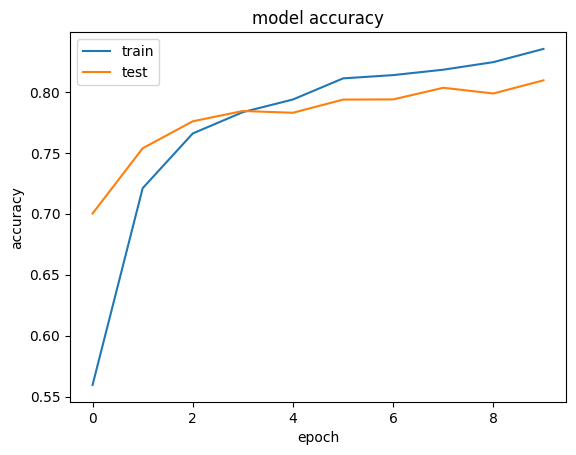

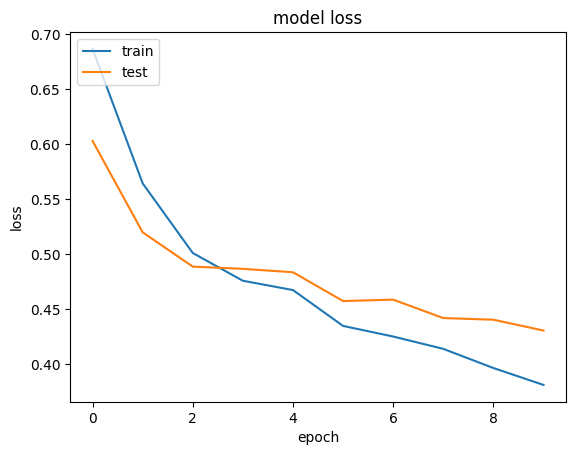

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Accuracy: {accuracy * 100:.2f}%')

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8154 - loss: 0.4312
Accuracy: 82.51%


In [ ]:
model.save("model.h5")

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)